In [1]:
import os
import torch
from tqdm import tqdm
from utils import Classification_Model, Standard_DataLoader, Trainer, load_rgb_mean_std

In [2]:
CWD = os.getcwd()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE_NAME = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'

print(f"CWD: {CWD}")
print(f"DEVICE: {DEVICE_NAME}")

CWD: /mnt/e/xAI-WriterIdentification/HI-EXP/classifier_NN
DEVICE: NVIDIA GeForce RTX 3060


In [3]:
MODEL_PATH = CWD + "/cp/Test_3_TL_val_best_model.pth"
TEST_ID = "CVL-0001"
DATASET_DIR = CWD + f"/tests/{TEST_ID}"
OUTPUT_DIR = CWD + f"/tests/{TEST_ID}/output"
SOURCE_DATA_DIR = CWD + "/../../datasets/CVL_Pages"

if not os.path.exists(DATASET_DIR):
    os.mkdir(DATASET_DIR)
    os.mkdir(DATASET_DIR + "/train")
    os.mkdir(DATASET_DIR + "/val")
    os.mkdir(DATASET_DIR + "/test")

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [4]:
writer_ids = ['0322', '0018', '0012', '0602', '0556', '0016', '0041']

# Phase 1 -> Dataset Splitting

In [5]:
pages = os.listdir(SOURCE_DATA_DIR)
for i in tqdm(range(0, len(pages)), desc="Splitting Dataset"):
    p = pages[i]
    writer_id = p.split("-")[0]
    page_id = int(p.split("-")[1])

    if writer_id in writer_ids:

        if not os.path.exists(DATASET_DIR + f"/train/{writer_id}"):
            os.mkdir(DATASET_DIR + f"/train/{writer_id}")
        if not os.path.exists(DATASET_DIR + f"/val/{writer_id}"):
            os.mkdir(DATASET_DIR + f"/val/{writer_id}")
        if not os.path.exists(DATASET_DIR + f"/test/{writer_id}"):
            os.mkdir(DATASET_DIR + f"/test/{writer_id}")
    
        if page_id in [1,3,4]:          # Train Pages
            os.system(f"cp " + SOURCE_DATA_DIR + f"/{p} " + DATASET_DIR + f"/train/{writer_id}/{p}")
        elif page_id == 2:              # Validation Pages
            os.system(f"cp " + SOURCE_DATA_DIR + f"/{p} " + DATASET_DIR + f"/val/{writer_id}/{p}")
        elif page_id == 6:              # Test Pages
            os.system(f"cp " + SOURCE_DATA_DIR + f"/{p} " + DATASET_DIR + f"/test/{writer_id}/{p}")
        else:
            continue

Splitting Dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1604/1604 [00:02<00:00, 641.92it/s]


# Phase 2 -> System Fine-Tuning

In [6]:
num_classes = len(os.listdir(DATASET_DIR + "/train"))
model = Classification_Model(num_classes=num_classes, mode='frozen', cp_path=MODEL_PATH)
model = model.to(DEVICE)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of trainable parameters: {pytorch_total_params}')

Number of trainable parameters: 33095


In [7]:
mean_, std_ = load_rgb_mean_std(f"{DATASET_DIR}/train")
train_ds = Standard_DataLoader(directory=f"{DATASET_DIR}/train", batch_size=32, weighted_sampling=True, phase='train', mean=mean_, std=std_, shuffle=True)
val_ds = Standard_DataLoader(directory=f"{DATASET_DIR}/val", batch_size=32, weighted_sampling=False, phase='val', mean=mean_, std=std_, shuffle=False)
tds, t_dl = train_ds.load_data()
vds, v_dl = val_ds.load_data()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.88it/s]


In [8]:
os.mkdir(f"{OUTPUT_DIR}/checkpoints")
torch.backends.cudnn.benchmark = True
trainer = Trainer(model=model, t_set=t_dl, v_set=v_dl, DEVICE=DEVICE, optim_type='adamw', lr_=0.02, 
                  model_path=OUTPUT_DIR, history_path=OUTPUT_DIR, test_ID=TEST_ID, num_epochs=100)
trainer()

Epoch 1 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]


train_loss: 1.9906185865402222 - train_accuracy: 0.09523809523809523



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


val_loss: 5.996195316314697 - val_accuracy: 0.14285714285714285

Epoch 2 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


train_loss: 2.1265788078308105 - train_accuracy: 0.09523809523809523



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


val_loss: 8.986891746520996 - val_accuracy: 0.14285714285714285

Epoch 3 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


train_loss: 2.034663200378418 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


val_loss: 10.678277969360352 - val_accuracy: 0.14285714285714285

Epoch 4 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


train_loss: 1.8207584619522095 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


val_loss: 12.401755332946777 - val_accuracy: 0.14285714285714285

Epoch 5 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


train_loss: 1.9925658702850342 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


val_loss: 10.049741744995117 - val_accuracy: 0.14285714285714285

Epoch 6 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


train_loss: 1.8868669271469116 - train_accuracy: 0.09523809523809523



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


val_loss: 10.058408737182617 - val_accuracy: 0.14285714285714285

Epoch 7 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


train_loss: 1.8925670385360718 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


val_loss: 8.716914176940918 - val_accuracy: 0.14285714285714285

Epoch 8 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


train_loss: 1.7419450283050537 - train_accuracy: 0.42857142857142855



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


val_loss: 7.351677417755127 - val_accuracy: 0.14285714285714285

Epoch 9 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


train_loss: 1.7587846517562866 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


val_loss: 7.339020252227783 - val_accuracy: 0.14285714285714285

Epoch 10 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


train_loss: 1.8020715713500977 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


val_loss: 6.5136213302612305 - val_accuracy: 0.14285714285714285

Epoch 11 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


train_loss: 1.9728624820709229 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


val_loss: 5.6269941329956055 - val_accuracy: 0.14285714285714285

Epoch 12 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


train_loss: 1.963305115699768 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


val_loss: 5.484058856964111 - val_accuracy: 0.14285714285714285

Epoch 13 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


train_loss: 1.8334083557128906 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


val_loss: 4.889489650726318 - val_accuracy: 0.14285714285714285

Epoch 14 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


train_loss: 2.044759750366211 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


val_loss: 4.458846569061279 - val_accuracy: 0.14285714285714285

Epoch 15 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


train_loss: 1.7468345165252686 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


val_loss: 3.6989552974700928 - val_accuracy: 0.14285714285714285

Epoch 16 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


train_loss: 2.0457870960235596 - train_accuracy: 0.09523809523809523



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


val_loss: 3.837059497833252 - val_accuracy: 0.14285714285714285

Epoch 17 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


train_loss: 2.029132843017578 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


val_loss: 3.8359017372131348 - val_accuracy: 0.14285714285714285

Epoch 18 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


train_loss: 2.040590763092041 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


val_loss: 3.706364870071411 - val_accuracy: 0.14285714285714285

Epoch 19 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


train_loss: 2.038346529006958 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


val_loss: 2.8425047397613525 - val_accuracy: 0.14285714285714285

Epoch 20 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


train_loss: 1.924149513244629 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


val_loss: 2.7396011352539062 - val_accuracy: 0.14285714285714285

Epoch 21 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


train_loss: 1.923308253288269 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


val_loss: 2.410764217376709 - val_accuracy: 0.2857142857142857

Epoch 22 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


train_loss: 1.9747705459594727 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


val_loss: 2.096184730529785 - val_accuracy: 0.2857142857142857

Epoch 23 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


train_loss: 1.859345555305481 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


val_loss: 2.2058300971984863 - val_accuracy: 0.14285714285714285

Epoch 24 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


train_loss: 1.6255117654800415 - train_accuracy: 0.42857142857142855



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


val_loss: 1.9534868001937866 - val_accuracy: 0.2857142857142857

Epoch 25 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


train_loss: 1.800166130065918 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


val_loss: 2.2409024238586426 - val_accuracy: 0.14285714285714285

Epoch 26 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


train_loss: 1.927040696144104 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


val_loss: 2.087428331375122 - val_accuracy: 0.14285714285714285

Epoch 27 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


train_loss: 2.09083890914917 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


val_loss: 2.076063871383667 - val_accuracy: 0.2857142857142857

Epoch 28 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


train_loss: 2.0752992630004883 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


val_loss: 2.019564390182495 - val_accuracy: 0.2857142857142857

Epoch 29 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


train_loss: 1.6840295791625977 - train_accuracy: 0.38095238095238093



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


val_loss: 1.9200718402862549 - val_accuracy: 0.14285714285714285

Epoch 30 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


train_loss: 1.7938382625579834 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


val_loss: 2.0194664001464844 - val_accuracy: 0.2857142857142857

Epoch 31 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


train_loss: 1.9002282619476318 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


val_loss: 2.1035702228546143 - val_accuracy: 0.14285714285714285

Epoch 32 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


train_loss: 1.8614981174468994 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


val_loss: 1.939434289932251 - val_accuracy: 0.42857142857142855

Epoch 33 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


train_loss: 1.936495065689087 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


val_loss: 2.065730571746826 - val_accuracy: 0.14285714285714285

Epoch 34 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


train_loss: 1.9961433410644531 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


val_loss: 2.135395050048828 - val_accuracy: 0.2857142857142857

Epoch 35 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


train_loss: 1.9384856224060059 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


val_loss: 2.207840919494629 - val_accuracy: 0.14285714285714285

Epoch 36 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


train_loss: 1.8445965051651 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


val_loss: 2.1068496704101562 - val_accuracy: 0.14285714285714285

Epoch 37 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


train_loss: 1.6962350606918335 - train_accuracy: 0.47619047619047616



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


val_loss: 2.361152410507202 - val_accuracy: 0.0

Epoch 38 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


train_loss: 2.089202404022217 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


val_loss: 2.639129400253296 - val_accuracy: 0.14285714285714285

Epoch 39 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


train_loss: 1.9526563882827759 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


val_loss: 2.7603511810302734 - val_accuracy: 0.14285714285714285

Epoch 40 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


train_loss: 1.7067829370498657 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


val_loss: 3.0394771099090576 - val_accuracy: 0.14285714285714285

Epoch 41 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


train_loss: 2.0616188049316406 - train_accuracy: 0.09523809523809523



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


val_loss: 3.0511069297790527 - val_accuracy: 0.14285714285714285

Epoch 42 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


train_loss: 1.595590353012085 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


val_loss: 3.085115432739258 - val_accuracy: 0.14285714285714285

Epoch 43 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


train_loss: 2.0154073238372803 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


val_loss: 3.329706907272339 - val_accuracy: 0.14285714285714285

Epoch 44 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


train_loss: 1.9148244857788086 - train_accuracy: 0.09523809523809523



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


val_loss: 2.704035520553589 - val_accuracy: 0.14285714285714285

Epoch 45 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


train_loss: 2.0055651664733887 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


val_loss: 2.59407639503479 - val_accuracy: 0.0

Epoch 46 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


train_loss: 1.8437020778656006 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


val_loss: 2.6066105365753174 - val_accuracy: 0.2857142857142857

Epoch 47 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


train_loss: 1.7231525182724 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


val_loss: 2.269774913787842 - val_accuracy: 0.2857142857142857

Epoch 48 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


train_loss: 1.8073327541351318 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


val_loss: 2.0714452266693115 - val_accuracy: 0.42857142857142855

Epoch 49 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


train_loss: 1.7429815530776978 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


val_loss: 2.61448335647583 - val_accuracy: 0.14285714285714285

Epoch 50 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


train_loss: 1.81936776638031 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


val_loss: 3.249011278152466 - val_accuracy: 0.14285714285714285

Epoch 51 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


train_loss: 2.073728322982788 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


val_loss: 4.201458930969238 - val_accuracy: 0.14285714285714285

Epoch 52 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


train_loss: 1.9058332443237305 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


val_loss: 4.793852806091309 - val_accuracy: 0.14285714285714285

Epoch 53 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


train_loss: 1.9450693130493164 - train_accuracy: 0.047619047619047616



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


val_loss: 4.818844318389893 - val_accuracy: 0.14285714285714285

Epoch 54 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


train_loss: 1.608237862586975 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


val_loss: 4.233216285705566 - val_accuracy: 0.14285714285714285

Epoch 55 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


train_loss: 2.051034927368164 - train_accuracy: 0.0



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


val_loss: 4.129397869110107 - val_accuracy: 0.14285714285714285

Epoch 56 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss: 2.2140543460845947 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


val_loss: 3.3549249172210693 - val_accuracy: 0.14285714285714285

Epoch 57 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


train_loss: 1.8642332553863525 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


val_loss: 3.324652910232544 - val_accuracy: 0.14285714285714285

Epoch 58 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


train_loss: 1.6480951309204102 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


val_loss: 2.9853575229644775 - val_accuracy: 0.14285714285714285

Epoch 59 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


train_loss: 1.9101923704147339 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


val_loss: 2.531331777572632 - val_accuracy: 0.14285714285714285

Epoch 60 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


train_loss: 1.821256399154663 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


val_loss: 2.6025307178497314 - val_accuracy: 0.14285714285714285

Epoch 61 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


train_loss: 2.0606818199157715 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


val_loss: 2.1827266216278076 - val_accuracy: 0.14285714285714285

Epoch 62 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


train_loss: 1.641730546951294 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


val_loss: 2.0411455631256104 - val_accuracy: 0.2857142857142857

Epoch 63 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


train_loss: 1.8348166942596436 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


val_loss: 1.9120051860809326 - val_accuracy: 0.14285714285714285

Epoch 64 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


train_loss: 1.7233788967132568 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


val_loss: 1.994903326034546 - val_accuracy: 0.14285714285714285

Epoch 65 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


train_loss: 1.7445485591888428 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


val_loss: 2.2298388481140137 - val_accuracy: 0.14285714285714285

Epoch 66 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


train_loss: 1.6803789138793945 - train_accuracy: 0.47619047619047616



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


val_loss: 2.2357430458068848 - val_accuracy: 0.14285714285714285

Epoch 67 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


train_loss: 1.850022315979004 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


val_loss: 2.2532296180725098 - val_accuracy: 0.14285714285714285

Epoch 68 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


train_loss: 1.7174474000930786 - train_accuracy: 0.42857142857142855



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


val_loss: 2.5081913471221924 - val_accuracy: 0.14285714285714285

Epoch 69 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


train_loss: 1.9775404930114746 - train_accuracy: 0.14285714285714285



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


val_loss: 2.108522891998291 - val_accuracy: 0.2857142857142857

Epoch 70 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


train_loss: 1.652748465538025 - train_accuracy: 0.38095238095238093



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


val_loss: 2.641570806503296 - val_accuracy: 0.14285714285714285

Epoch 71 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


train_loss: 1.8392804861068726 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


val_loss: 1.8271729946136475 - val_accuracy: 0.2857142857142857

Epoch 72 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


train_loss: 1.6834825277328491 - train_accuracy: 0.47619047619047616



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


val_loss: 2.056095838546753 - val_accuracy: 0.2857142857142857

Epoch 73 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


train_loss: 1.708982229232788 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


val_loss: 1.729645848274231 - val_accuracy: 0.14285714285714285

Epoch 74 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


train_loss: 1.7285107374191284 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


val_loss: 1.6978435516357422 - val_accuracy: 0.2857142857142857

Epoch 75 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


train_loss: 1.8693361282348633 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


val_loss: 1.759497046470642 - val_accuracy: 0.2857142857142857

Epoch 76 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


train_loss: 1.583363652229309 - train_accuracy: 0.38095238095238093



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val_loss: 1.8962050676345825 - val_accuracy: 0.2857142857142857

Epoch 77 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


train_loss: 1.6250388622283936 - train_accuracy: 0.5238095238095238



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


val_loss: 1.8772212266921997 - val_accuracy: 0.2857142857142857

Epoch 78 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


train_loss: 1.9923768043518066 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


val_loss: 1.9581161737442017 - val_accuracy: 0.2857142857142857

Epoch 79 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


train_loss: 2.2099833488464355 - train_accuracy: 0.09523809523809523



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


val_loss: 2.1765589714050293 - val_accuracy: 0.2857142857142857

Epoch 80 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


train_loss: 2.0668678283691406 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


val_loss: 2.434729814529419 - val_accuracy: 0.14285714285714285

Epoch 81 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


train_loss: 1.7198069095611572 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val_loss: 2.6344380378723145 - val_accuracy: 0.14285714285714285

Epoch 82 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


train_loss: 1.5668714046478271 - train_accuracy: 0.42857142857142855



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


val_loss: 2.587982654571533 - val_accuracy: 0.14285714285714285

Epoch 83 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


train_loss: 1.9008744955062866 - train_accuracy: 0.23809523809523808



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


val_loss: 2.2674152851104736 - val_accuracy: 0.14285714285714285

Epoch 84 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


train_loss: 1.6892943382263184 - train_accuracy: 0.5238095238095238



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


val_loss: 2.0055227279663086 - val_accuracy: 0.14285714285714285

Epoch 85 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


train_loss: 1.5493167638778687 - train_accuracy: 0.42857142857142855



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


val_loss: 2.2106330394744873 - val_accuracy: 0.14285714285714285

Epoch 86 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


train_loss: 1.7057245969772339 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


val_loss: 2.0996205806732178 - val_accuracy: 0.14285714285714285

Epoch 87 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


train_loss: 1.7475908994674683 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val_loss: 1.5184568166732788 - val_accuracy: 0.2857142857142857

Epoch 88 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


train_loss: 1.717012643814087 - train_accuracy: 0.38095238095238093



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


val_loss: 1.6155385971069336 - val_accuracy: 0.2857142857142857

Epoch 89 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


train_loss: 1.6864852905273438 - train_accuracy: 0.38095238095238093



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


val_loss: 2.074065685272217 - val_accuracy: 0.14285714285714285

Epoch 90 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


train_loss: 1.6537039279937744 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


val_loss: 2.714749813079834 - val_accuracy: 0.14285714285714285

Epoch 91 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


train_loss: 1.549898624420166 - train_accuracy: 0.38095238095238093



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


val_loss: 2.326794385910034 - val_accuracy: 0.42857142857142855

Epoch 92 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


train_loss: 2.113006353378296 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


val_loss: 2.5204551219940186 - val_accuracy: 0.2857142857142857

Epoch 93 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


train_loss: 1.659056305885315 - train_accuracy: 0.42857142857142855



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


val_loss: 2.834596872329712 - val_accuracy: 0.14285714285714285

Epoch 94 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


train_loss: 1.4669603109359741 - train_accuracy: 0.47619047619047616



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


val_loss: 3.1756389141082764 - val_accuracy: 0.14285714285714285

Epoch 95 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


train_loss: 1.6262232065200806 - train_accuracy: 0.38095238095238093



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


val_loss: 2.3350412845611572 - val_accuracy: 0.14285714285714285

Epoch 96 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


train_loss: 1.5014142990112305 - train_accuracy: 0.42857142857142855



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


val_loss: 1.9379689693450928 - val_accuracy: 0.14285714285714285

Epoch 97 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


train_loss: 1.7409543991088867 - train_accuracy: 0.3333333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


val_loss: 1.7004917860031128 - val_accuracy: 0.2857142857142857

Epoch 98 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


train_loss: 1.8133572340011597 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


val_loss: 1.9081095457077026 - val_accuracy: 0.14285714285714285

Epoch 99 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


train_loss: 1.9631520509719849 - train_accuracy: 0.19047619047619047



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


val_loss: 1.840983510017395 - val_accuracy: 0.2857142857142857

Epoch 100 / 100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


train_loss: 1.7112953662872314 - train_accuracy: 0.2857142857142857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]

val_loss: 2.110166072845459 - val_accuracy: 0.14285714285714285



# Phase 3 -> Print Results for Training -> Phase 3

In [9]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

In [10]:
losses = {'train': [], 'val': []}
accs = {'train': [], 'val': []}

In [11]:
for loss in list(losses.keys()):
    with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_{loss}_losses.pkl', 'rb') as f:
        losses[loss] = pkl.load(f)

In [12]:
with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_losses.txt', 'w') as f:
    f.write('The optimal value of loss for the training set is: {:01.3f}\n'.format(np.min(losses['train'])))
    f.write('The optimal value of loss for the validation set is: {:01.3f}\n'.format(np.min(losses['val'])))
    best_epoch_train = np.where(np.array(losses['train']) == min(losses['train']))[0][0] + 1
    best_epoch = np.where(np.array(losses['val']) == min(losses['val']))[0][0] + 1
    f.write(f"Epoch corresponding to the optimal value of the training loss: {best_epoch_train}\\{len(losses['train'])}\n")
    f.write(f"Epoch corresponding to the optimal value of the validation loss: {best_epoch}\\{len(losses['val'])}\n")

In [13]:
plt.plot(losses['train'])
plt.plot(losses['val'])
plt.title('Model loss')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.legend(['Training', 'Validation'], loc='best')
plt.savefig(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_losses.png')
plt.close()

In [14]:
for acc in list(accs.keys()):
    with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_{acc}_accuracy.pkl', 'rb') as f:
        accs[acc] = pkl.load(f)

In [15]:
with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_accuracy.txt', 'w') as f:
    f.write('The optimal value of accuracy for the training set is: {:01.3f}\n'.format(np.max(accs['train'])))
    f.write('The optimal value of accuracy for the validation set is: {:01.3f}\n'.format(np.max(accs['val'])))
    best_epoch_train = np.where(np.array(accs['train']) == max(accs['train']))[0][0] + 1
    best_epoch = np.where(np.array(accs['val']) == max(accs['val']))[0][0] + 1
    f.write(f"Epoch corresponding to the optimal value of the training accuracy: {best_epoch_train}\\{len(accs['train'])}\n")
    f.write(f"Epoch corresponding to the optimal value of the validation accuracy: {best_epoch}\\{len(accs['val'])}\n")

In [16]:
plt.plot(accs['train'])
plt.plot(accs['val'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy [-]')
plt.xlabel('Epoch [-]')
plt.legend(['Training', 'Validation'], loc='best')
plt.savefig(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_accuracy.png')
plt.close()  

# Phase 4 -> Testing & Reports

In [17]:
torch.cuda.empty_cache()

In [18]:
from utils import Classification_Model, Standard_DataLoader, load_rgb_mean_std, produce_classification_reports

In [19]:
cp_base = f"./cp/Test_3_TL_val_best_model.pth"
cp = f"{OUTPUT_DIR}/checkpoints/Test_{TEST_ID}_MLC_val_best_model.pth"
num_classes = len(os.listdir(DATASET_DIR + "/test"))

In [20]:
model = Classification_Model(num_classes=num_classes, mode='frozen', cp_path=cp_base)
model = model.to(DEVICE)
model.load_state_dict(torch.load(cp)['model_state_dict'])
model.eval()

Classification_Model(
  (base_model): BaseModel(
    (enc): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

/home/xodiec/.pyenv/versions/3.10.12/envs/NewVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xodiec/.pyenv/versions/3.10.12/envs/NewVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xodiec/.pyenv/versions/3.10.12/envs/NewVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

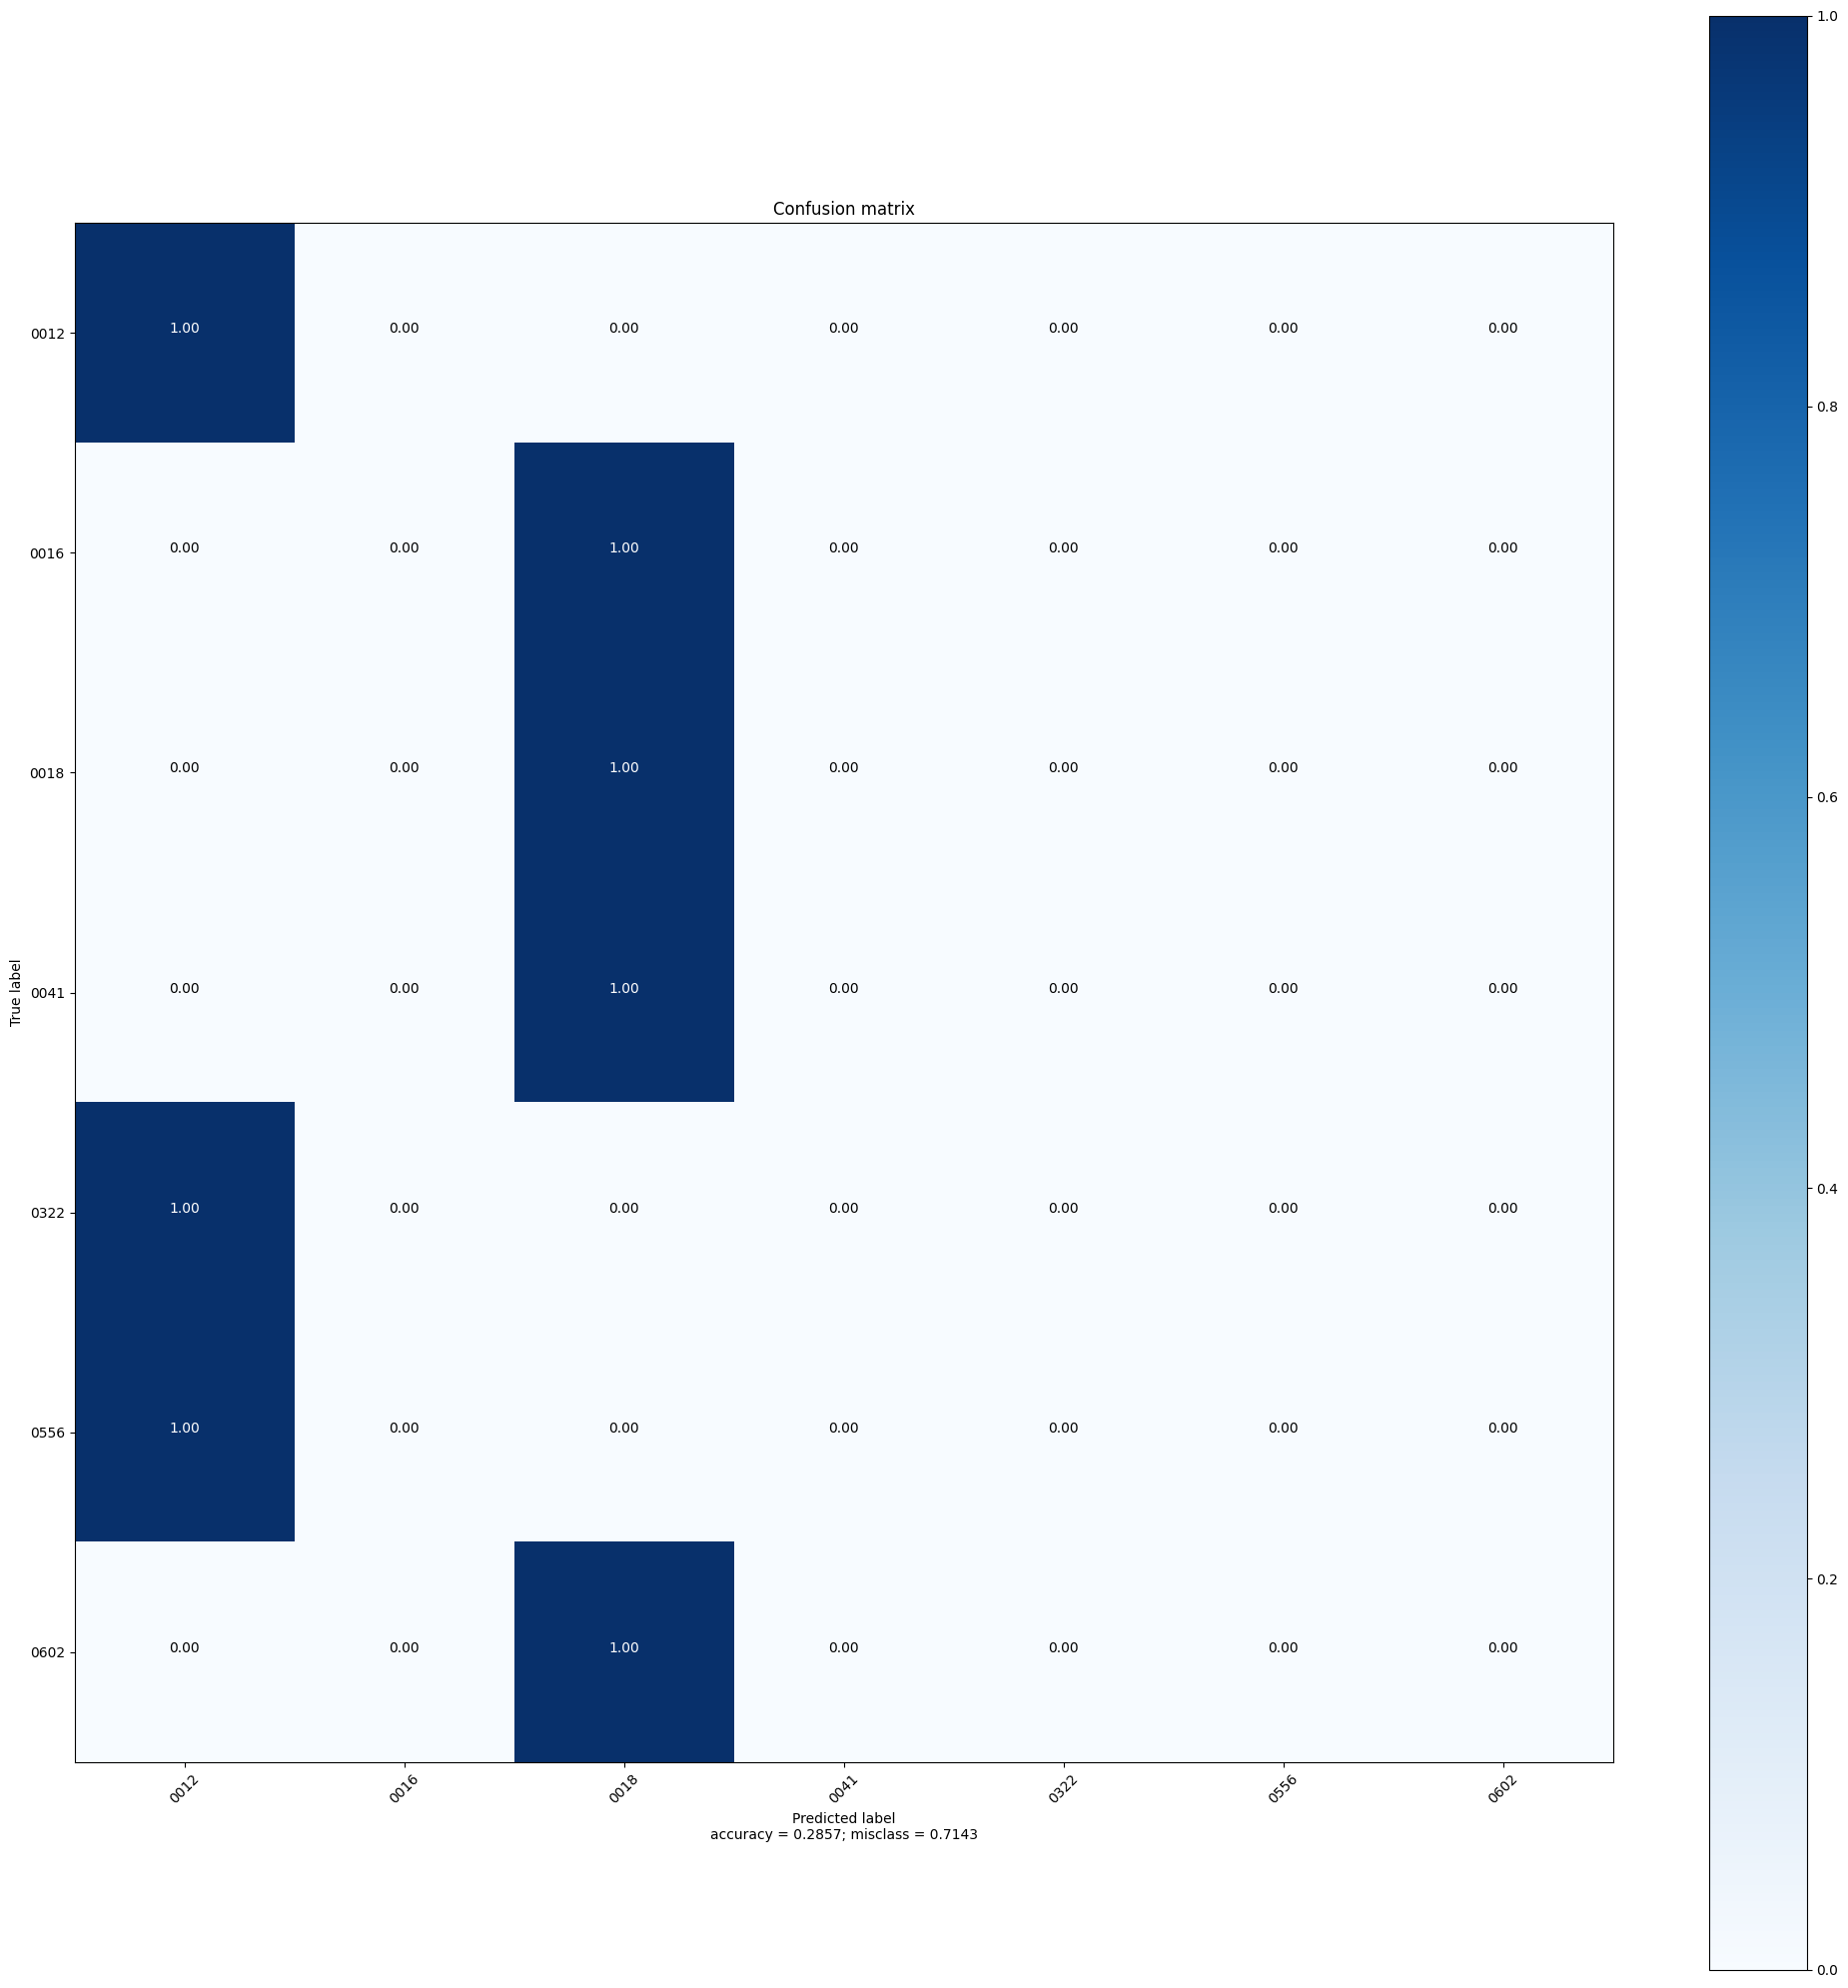

In [22]:
mean_, std_ = load_rgb_mean_std(f"{DATASET_DIR}/train")
dl = Standard_DataLoader(f"{DATASET_DIR}/test", 64, False, 'test', mean_, std_, True)
produce_classification_reports(dl, DEVICE, model, OUTPUT_DIR, TEST_ID)